In [3]:
import numpy as np
import pandas as pd
import pickle
import time
import os
import csv
import shutil

import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom
import imageio
import glob
import boto3

from lungmask import LMInferer

from tqdm.notebook import tqdm
from collections import namedtuple

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

## Helper Functions

In [7]:
def inferer_mask(ct_scan_volume, offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of generated mask
    '''
    inferer = LMInferer()
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan_volume -= offset
    mask_slices = []
    lung_mask_volume = inferer.apply(ct_scan_volume)
    for slice_idx in range(ct_scan_volume.shape[0]):
        mask_slices.append(lung_mask_volume[slice_idx, :, :])

    mask_slices = np.stack(mask_slices, axis=0)
    
    return mask_slices

In [8]:
def segmented_inferer_volume(ct_scan,offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of segmented volume
    '''
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan -= offset
    print('max:',ct_scan.max())
    print('min:',ct_scan.min())
    lung_mask_volume = inferer_mask(ct_scan)
    segmented_slices = []
    tracker = []
    for slice_idx in range(ct_scan.shape[0]):
        ct_slice = ct_scan[slice_idx, :, :]
        lung_mask_slice = lung_mask_volume[slice_idx, :, :]
        masked_slice = np.where(lung_mask_slice != 0, ct_slice, np.min(ct_slice))
        segmented_slices.append(masked_slice)
        
        #keeps track of value ranges only in lungs
        tracker_slice = np.where(lung_mask_slice != 0, ct_slice, -99999)
        tracker.append(tracker_slice)
        
    segmented_slices = np.stack(segmented_slices, axis=0)
    
    # Concatenate the arrays into a single array
    concatenated_array = np.concatenate(tracker)
    
    # Filter the array to exclude values equal to -99999
    concatenated_array  = concatenated_array[concatenated_array  != -99999]

    # Find the minimum and maximum values inside lung volume
    min_value = np.min(concatenated_array)
    max_value = np.max(concatenated_array)

    # Normalize the segmented volume to a range of 0 to 1
    segmented_slices = (segmented_slices - min_value) / (max_value - min_value)
    
    #Replace background with 0's
    background_value = segmented_slices[0][0][0]
    segmented_slices = np.where(segmented_slices == background_value, 0, segmented_slices)
    
    
    return segmented_slices

In [30]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

    
def load_itk(filename):
    """Reading a '.mhd' file using SimpleITK. Returns the image array, origin and spacing of the image"""
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)  # axis in the order z,y,x
    
    # origin is used to convert the coordinates from world to voxel 
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing


def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    for i, el in enumerate(voxel_coordinates):
        voxel_coordinates[i] = int(el)
    return voxel_coordinates


def save_to_npy(input_path, folder_output, candidates, subs_id, width_size=32):
    all_files = [f for f in listdir(input_path) if isfile(join(input_path, f)) and '.mhd' in f]
    cands = pd.read_csv(candidates, header=None)

    y_train = []
    counter = 0
    for name in tqdm(all_files):
        image_samples = cands[cands[0] == name[:-4]]
        for index, row in image_samples.iterrows():
            image_name = join(input_path, name)
            # GET COORDINATES
            lung_img = sitk.GetArrayFromImage(sitk.ReadImage(image_name))
            _, orig, spac = load_itk(image_name)
            vox_coords = world_2_voxel([float(row[3]), float(row[2]), float(row[1])], orig, spac)

            # CLASS: 0 - nonnodule, 1 - nodule
            y_class = int(row[4])

            # CROP IMAGE
            w = width_size / 2
            patch = lung_img[int(vox_coords[0] - w): int(vox_coords[0] + w),
                    int(vox_coords[1] - w): int(vox_coords[1] + w),
                    int(vox_coords[2] - w): int(vox_coords[2] + w)]

            # print([row[0], patch.shape, y_class])
            try:
                if y_class == 1:
                    # FOR NODULES WE ADD ALL IMAGES
                    if width_size < 60:
                        for p in range(width_size):
                            np.save(join(folder_output, 'X_train_{}_{}.npy'.format(str(folder_output[-1]), counter)),
                                        np.resize(patch[p, :, :], (1, 32, 32)))
                            y_train.append(y_class)
                            counter += 1

                    else:
                        for p in range(16, 48):
                            np.save(join(folder_output, 'X_train_{}_{}.npy'.format(str(folder_output[-1]), counter)),
                                    np.resize(patch[p, :, :], (1, 64, 64)))
                            y_train.append(y_class)
                            counter += 1

                elif y_class == 0:
                    rand_img = randint(0, width_size - 1)  # choosing randomimage out of all nonnodules
                    np.save(join(folder_output, 'X_train_{}_{}.npy'.format(str(folder_output[-1]), counter)),
                                np.resize(patch[rand_img, :, :], (1, 32, 32)))
                    y_train.append(y_class)
                    counter += 1

            except:
                pass
    np.save(join(folder_output, 'y_train_{}.npy'.format(str(folder_output[-1]))), y_train)

    return 'Done!'  
       
    
    
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]    

In [7]:
def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

In [8]:
def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))


##

In [4]:
import copy
import csv
import functools
import glob
import os

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
from torch.utils.data import Dataset

from util.disk import getCache
from util.util import XyzTuple, xyz2irc
from util.logconf import logging

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

raw_cache = getCache('part2ch10_raw')

CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, diameter_mm, series_uid, center_xyz',
)

@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('luna16/raw*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('luna16/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefault(series_uid, []).append(
                (annotationCenter_xyz, annotationDiameter_mm)
            )

    candidateInfo_list = []
    with open('luna16/candidates.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

            candidateDiameter_mm = 0.0
            for annotation_tup in diameter_dict.get(series_uid, []):
                annotationCenter_xyz, annotationDiameter_mm = annotation_tup
                for i in range(3):
                    delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
                    if delta_mm > annotationDiameter_mm / 4:
                        break
                else:
                    candidateDiameter_mm = annotationDiameter_mm
                    break

            candidateInfo_list.append(CandidateInfoTuple(
                isNodule_bool,
                candidateDiameter_mm,
                series_uid,
                candidateCenter_xyz,
            ))

    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            'luna16/raw/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]

        return ct_chunk, center_irc


@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())

        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list

        log.info("{!r}: {} {} samples".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
        ))

    def __len__(self):
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        candidateInfo_tup = self.candidateInfo_list[ndx]
        width_irc = (32, 48, 48)

        candidate_a, center_irc = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            width_irc,
        )

        candidate_t = torch.from_numpy(candidate_a)
        candidate_t = candidate_t.to(torch.float32)
        candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return (
            candidate_t,
            pos_t,
            candidateInfo_tup.series_uid,
            torch.tensor(center_irc),
        )

In [3]:
def get_cube_from_img(img3d, center, block_size):
    """"Code for this function is based on code from this repository: https://github.com/junqiangchen/LUNA16-Lung-Nodule-Analysis-2016-Challenge"""
    # get roi(z,y,z) image and in order the out of img3d(z,y,x)range
    center_z = center[0]
    center_y = center[1]
    center_x = center[2]
    start_x = max(center_x - block_size / 2, 0)
    if start_x + block_size > img3d.shape[2]:
        start_x = img3d.shape[2] - block_size
    start_y = max(center_y - block_size / 2, 0)
    if start_y + block_size > img3d.shape[1]:
        start_y = img3d.shape[1] - block_size
    start_z = max(center_z - block_size / 2, 0)
    if start_z + block_size > img3d.shape[0]:
        start_z = img3d.shape[0] - block_size
    start_z = int(start_z)
    start_y = int(start_y)
    start_x = int(start_x)
    roi_img3d = img3d[start_z:start_z + block_size, start_y:start_y + block_size, start_x:start_x + block_size]
    return roi_img3d

## Iterates through all raw mhd files to generate 2D slices and 2D/3D Regions of Interest

In [4]:

image_size = 32
root_dir = 'luna16/raw'
output_cand_path = 'luna16/2D_Lung_Annotations/'
output_clean_path = 'luna16/2D_Lung_NonAnnotations/'
ThreeD_ROI_path = 'luna16/3D_annotation_ROI/'
TwoD_ROI_path = 'luna16/2D_annotation_ROI/'

mhd_file_paths = glob.glob(os.path.join(root_dir, '*.mhd'))
for mhd in mhd_file_paths:
    file_name = os.path.basename(mhd)[:-4]
    mhd_file = sitk.ReadImage(mhd)
    origin = mhd_file.GetOrigin()
    spacing = mhd_file.GetSpacing()
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    print('file_name',file_name)
    df_node = pd.read_csv('luna16/annotations.csv')
    slice_list = []
    for index, item in df_node.iterrows():
        if item['seriesuid'] == file_name:
            center = np.array([item['coordX'], item['coordY'], item['coordZ']])
            v_center = np.rint((center - origin) / spacing)
            v_center[0], v_center[1], v_center[2] = v_center[2], v_center[1], v_center[0]
            node_cube = get_cube_from_img(ct_scan, v_center, image_size)
            #print('z:',v_center[0])
            node_slice = int(v_center[0])
            #print(ct_scan.shape)
            #print(ct_scan.max())
            #print(ct_scan.min())
            #print(mhd_file.GetSpacing())
            #print(mhd_file.GetSize())
            #print(mhd_file.GetOrigin())
            #print(mhd_file.GetDirection())
            #print(mhd_file.GetPixelID())
            
            #Saves the Candidate Slice
            np.save(output_cand_path+str(file_name)+'_'+str(node_slice)+'.npy', ct_scan[node_slice])
            
            #Saves the 3D candidate ROI
            np.save(ThreeD_ROI_path+str(file_name)+'_'+str(node_slice)+'_3DROI'+'.npy', node_cube)
            
            #Saves the 2D candidate ROI
            np.save(TwoD_ROI_path+str(file_name)+'_'+str(node_slice)+'_2DROI'+'.npy', node_cube[16])
            
            #Collects candidate slice numbers
            slice_list.append(node_slice)
            
            # Displays an image slice
            #plt.imshow(ct_scan[node_slice], cmap='gray')
            #plt.show()

            #plt.imshow(node_cube[16], cmap='gray')
            #plt.show()
    
    #Saves the Clean 2D Slices from volume       
    for i in range(0, ct_scan.shape[0]):
        if i not in slice_list:
            np_file = np.save(output_clean_path+str(file_name)+'_'+str(i)+'.npy', ct_scan[i])

'''
	coordX	coordY	coordZ
-24.0138242	192.1024053	-391.0812764
'''

file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.183184435049555024219115904825
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.458525794434429386945463560826
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033132458296975008261
file_name 1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827
file_name 1.3.6.1.4.1.145

'\n\tcoordX\tcoordY\tcoordZ\n-24.0138242\t192.1024053\t-391.0812764\n'

## Test Cell for Region of Interest

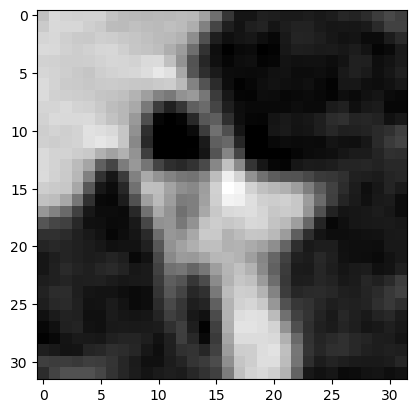

In [15]:
data = np.load('luna16/3D_ROIs/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969_287_3DROI.npy')
plt.imshow(data[16], cmap='gray')
plt.show()

In [ ]:
center = np.array([x, y, z])
                v_center = np.rint((center - origin) / spacing)
                
                # convert x,y,z order  to z,y,x  
                v_center[0], v_center[1], v_center[2] = v_center[2], v_center[1], v_center[0]
                
                node_cube = get_cube_from_img(img_array, v_center, image_size)

In [ ]:
for subsetindex in tqdm(range(num_subsets)):
    luna_path = "luna16/raw"
    luna_subset_path = luna_path + "subset" + str(subsetindex) + "/"
    output_path = "/datagrid/temporary/dobkomar/output_path_32/"
    file_list = glob(luna_subset_path + "*.mhd")

    luna_csv_path = "/datagrid/Medical/nodules/Luna/"
    df_node = pd.read_csv('/home.stud/dobkomar/candidates_V2.csv')
    df_node["file"] = df_node["seriesuid"].map(lambda file_name: [f for f in file_list if file_name in f][0])
    df_node = df_node.dropna()
    
    
    for fcount, img_file in enumerate(tqdm(file_list)):
        temp_df = df_node[df_node["file"] == img_file]

        if temp_df.shape[0] > 0:
            img_array, origin, spacing = load_itk_version2(img_file)

            index = 0
            for node_idx, row in temp_df.iterrows():
                x, y, z = row["coordX"], row["coordY"], row["coordZ"]
                label = row["class"]

                center = np.array([x, y, z])
                v_center = np.rint((center - origin) / spacing)
                
                # convert x,y,z order  to z,y,x  
                v_center[0], v_center[1], v_center[2] = v_center[2], v_center[1], v_center[0]
                
                node_cube = get_cube_from_img(img_array, v_center, image_size)
                node_cube.astype(np.uint8)

                if label == 1:
                    filepath = output_path + "1/"
                    if not os.path.exists(filepath):
                        os.makedirs(filepath)
                    filename = str(subsetindex) + "_" + str(fcount) + "_" + str(index) + '_' + str(row['seriesuid']) + '_' + str(x) + '_' + str(y) + '_' + str(z) +'_'+ str(label)  
                    np.save(filepath + filename + ".npy", node_cube)

                if label == 0:
                    filepath = output_path + "0/"
                    if not os.path.exists(filepath):
                        os.makedirs(filepath)
                    filename = str(subsetindex) + "_" + str(fcount) + "_" + str(index) + '_' + str(row['seriesuid']) + '_' + str(x) + '_' + str(y) + '_' + str(z) +'_'+ str(label)   
                    np.save(filepath + filename + ".npy", node_cube)
                index += 1

## Uploading data to S3

In [ ]:
import os
import boto3

# Set the name of your S3 bucket
bucket_name = 'fastvision.ai'

# Set the subfolder path within the bucket
subfolder_path = 'luna16_annotation_data/annotation_slices/'

# Set the path to your SageMaker folder
folder_path = 'luna16/2D_Lung_Annotations'

# Create an S3 client
s3_client = boto3.client('s3')

# Iterate through the files in the SageMaker folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Set the S3 key by combining the subfolder path and the filename
        s3_key = subfolder_path + filename
        
        # Upload the file to the S3 bucket
        s3_client.upload_file(file_path, bucket_name, s3_key)

        
        
# Set the name of your S3 bucket
bucket_name = 'fastvision.ai'

# Set the subfolder path within the bucket
subfolder_path = 'luna16_annotation_data/2D_ROIs/'

# Set the path to your SageMaker folder
folder_path = 'luna16/2D_annotation_ROI'

# Create an S3 client
s3_client = boto3.client('s3')

# Iterate through the files in the SageMaker folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Set the S3 key by combining the subfolder path and the filename
        s3_key = subfolder_path + filename
        
        # Upload the file to the S3 bucket
        s3_client.upload_file(file_path, bucket_name, s3_key)
        
        
# Set the name of your S3 bucket
bucket_name = 'fastvision.ai'

# Set the subfolder path within the bucket
subfolder_path = 'luna16_annotation_data/3D_ROIs/'

# Set the path to your SageMaker folder
folder_path = 'luna16/3D_annotation_ROI'

# Create an S3 client
s3_client = boto3.client('s3')

# Iterate through the files in the SageMaker folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Set the S3 key by combining the subfolder path and the filename
        s3_key = subfolder_path + filename
        
        # Upload the file to the S3 bucket
        s3_client.upload_file(file_path, bucket_name, s3_key)
        
        
# Set the name of your S3 bucket
bucket_name = 'fastvision.ai'

# Set the subfolder path within the bucket
subfolder_path = 'luna16_annotation_data/clean_slices/'

# Set the path to your SageMaker folder
folder_path = 'luna16/2D_Lung_NonAnnotations'

# Create an S3 client
s3_client = boto3.client('s3')

# Iterate through the files in the SageMaker folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Set the S3 key by combining the subfolder path and the filename
        s3_key = subfolder_path + filename
        
        # Upload the file to the S3 bucket
        s3_client.upload_file(file_path, bucket_name, s3_key)